In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold
from sklearn.metrics import mean_squared_error
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import re 

import nltk 
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from textblob import Word

from nltk.stem import WordNetLemmatizer

from nltk.tokenize import RegexpTokenizer
import matplotlib.cm as cm
from matplotlib import rcParams

from collections import Counter 



In [2]:
df = pd.read_csv('/content/drive/MyDrive/AIM_Task/final_dialect_dataset.csv',lineterminator='\n')
df.head()

,id,dialect,tweet
0,1175358310087892992,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1175450108898565888,IQ,@KanaanRema مبين من كلامه خليجي
3,1175471073770573824,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1175496913145217024,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺


In [3]:
df['dialect'].value_counts()

EG    57636
PL    43742
KW    42109
LY    36499
QA    31069
JO    27921
LB    27617
SA    26832
AE    26296
BH    26292
OM    19116
SY    16242
DZ    16183
IQ    15497
SD    14434
MA    11539
YE     9927
TN     9246
Name: dialect, dtype: int64

In [4]:

enc = LabelEncoder()
df['label'] = enc.fit_transform(df['dialect'])

class_names = df.groupby(['dialect', 'label']).count().reset_index().loc[:,['dialect', 'label']]

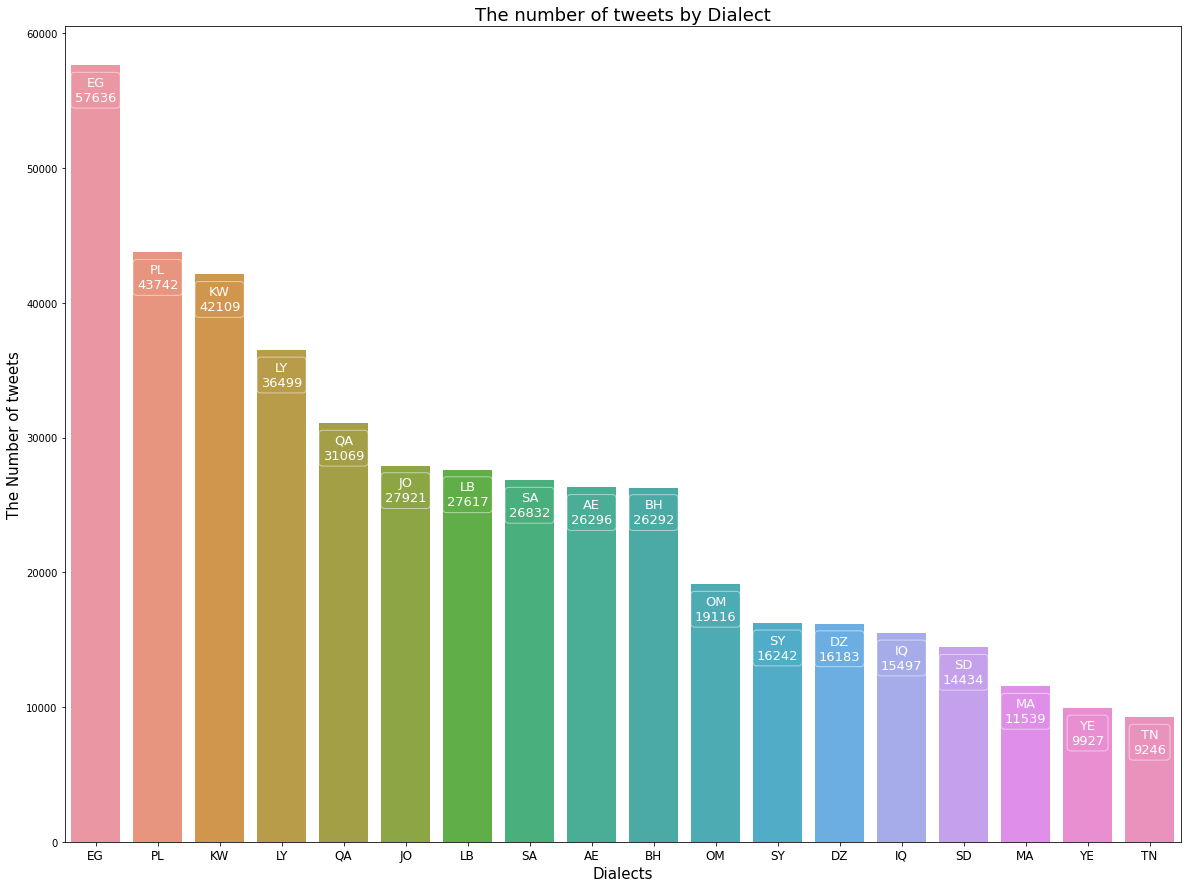

In [5]:
category_counts = df['dialect'].value_counts()
categories = category_counts.index

fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111)
sns.barplot(x = category_counts.index , y = category_counts)
for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
plt.xlabel('Dialects', size = 15)
plt.ylabel('The Number of tweets', size= 15)
plt.xticks(size = 12)

plt.title("The number of tweets by Dialect" , size = 18)
plt.show()

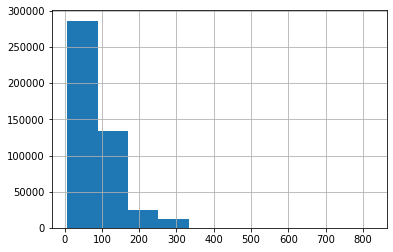

In [6]:
df['tweet'].str.len().hist()

In [7]:
nltk.download("stopwords")
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))



def remove_users(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(x))) # remove re-tweet
    df[col] = df[col].apply(lambda x: re.sub(r'(@[A-Za-z0-9-_]+)', '', str(x))) # remove tweeted at
    df[col] = df[col].apply(lambda x: re.sub(r'@[^\s]+[\s]?', '', str(x)))

def remove_special_char(df, col):
    """function to remove any special characters or english words"""
    df[col] = df[col].apply(lambda x: re.sub(r'&[\S]+?;', '', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'[^\w\s]', r'', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'#', ' ', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'\s*[A-Za-z]+\b', '' , str(x)))


def remove_links(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'http\S+', '', str(x)))  # remove http links
    df[col] = df[col].apply(lambda x: re.sub(r'bit.ly/\S+', '', str(x)))  # remove bit.ly links    

def remove_numerics(df, col):
    """function to remove numbers or words with digits"""
    df[col] = df[col].apply(lambda x: re.sub(r'\w*\d\w*', r'', str(x)))

def remove_whitespaces(df, col):
    """function to remove any double or more whitespaces to single and any leading and trailing whitespaces"""
    df[col] = df[col].apply(lambda x: re.sub(r'\s\s+', ' ', str(x))) 
    df[col] = df[col].apply(lambda x: re.sub(r'(\A\s+|\s+\Z)', '', str(x))) 

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def tokenize(df,col):
  tokenizer = RegexpTokenizer(r'\w+')
  df[col] = df[col].apply(tokenizer.tokenize)
  

    

def normalize(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return text
  
def normalize_text(df,col):
  df[col] = df[col].apply(normalize)


def preprocess_tweets(df, col):
    """master function to preprocess tweets"""
    remove_users(df, col)
    remove_links(df, col)
    remove_special_char(df, col)
    remove_whitespaces(df, col)
    remove_numerics(df, col)
    normalize_text(df,col)
    #tokenize(df,col)
    
    return df




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df['clean_text']=df['tweet']

In [9]:
preprocess_tweets(df, 'clean_text')
df

,id,dialect,tweet,label,clean_text
0,1175358310087892992,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,4,لكن بالنهايه ينتفض يغير
1,1175416117793349632,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,4,يعني هذا محسوب علي البشر حيونه ووحشيه وتطلبون ...
2,1175450108898565888,IQ,@KanaanRema مبين من كلامه خليجي,4,مبين من كلامه خليجي
3,1175471073770573824,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,4,يسلملي مرورك وروحك الحلوه
4,1175496913145217024,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,4,وين هل الغيبه اخ محمد
...,...,...,...,...,...
458192,1019484980282580992,BH,@Al_mhbaa_7 مبسوطين منك اللي باسطانا😅,1,مبسوطين منك اللي باسطانا
458193,1021083283709407232,BH,@Zzainabali @P_ameerah والله ماينده ابش يختي,1,والله ماينده ابش يختي
458194,1017477537889431552,BH,@Al_mhbaa_7 شو عملنا لك حنا تهربي مننا احنا مس...,1,شو عملنا لك حنا تهربي مننا احنا مساكين ليش بتع...
458195,1022430374696239232,BH,@haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋,1,الله يبارك فيها وبالعافيه


In [10]:
all = [word for tokens in df["clean_text"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["clean_text"]]

VOCAB = sorted(list(set(all)))

print("%s words total, with a vocabulary size of %s" % (len(all), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

31547488 words total, with a vocabulary size of 686
Max sentence length is 280


In [11]:
counter = Counter(all)
counter.most_common(50)

[(' ', 5471203),
 ('ا', 4061664),
 ('ل', 2664736),
 ('ي', 2508497),
 ('و', 1660552),
 ('م', 1595549),
 ('ن', 1480637),
 ('ه', 1454665),
 ('ب', 1168095),
 ('ر', 1123900),
 ('ت', 1072211),
 ('ع', 927750),
 ('ك', 805682),
 ('د', 722121),
 ('ح', 621029),
 ('ف', 616492),
 ('س', 609738),
 ('ق', 482610),
 ('ش', 480709),
 ('ج', 319010),
 ('ص', 272047),
 ('خ', 256384),
 ('ط', 238662),
 ('ز', 179655),
 ('ض', 128603),
 ('غ', 125824),
 ('ذ', 100728),
 ('\n', 92426),
 ('ء', 78183),
 ('ث', 66754),
 ('_', 61948),
 ('ظ', 40737),
 ('گ', 3099),
 ('ی', 2835),
 ('ﺎ', 2638),
 ('چ', 2634),
 ('ﻟ', 1992),
 ('ہ', 1898),
 ('ﺍ', 1739),
 ('ک', 1374),
 ('ﻣ', 1125),
 ('ﻴ', 1002),
 ('ﻭ', 986),
 ('ﻮ', 904),
 ('a', 890),
 ('ھ', 886),
 ('ﻻ', 850),
 ('ﻳ', 826),
 ('ﺑ', 819),
 ('ﺮ', 777)]

In [12]:
counted_words = Counter(all)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

<BarContainer object of 25 artists>

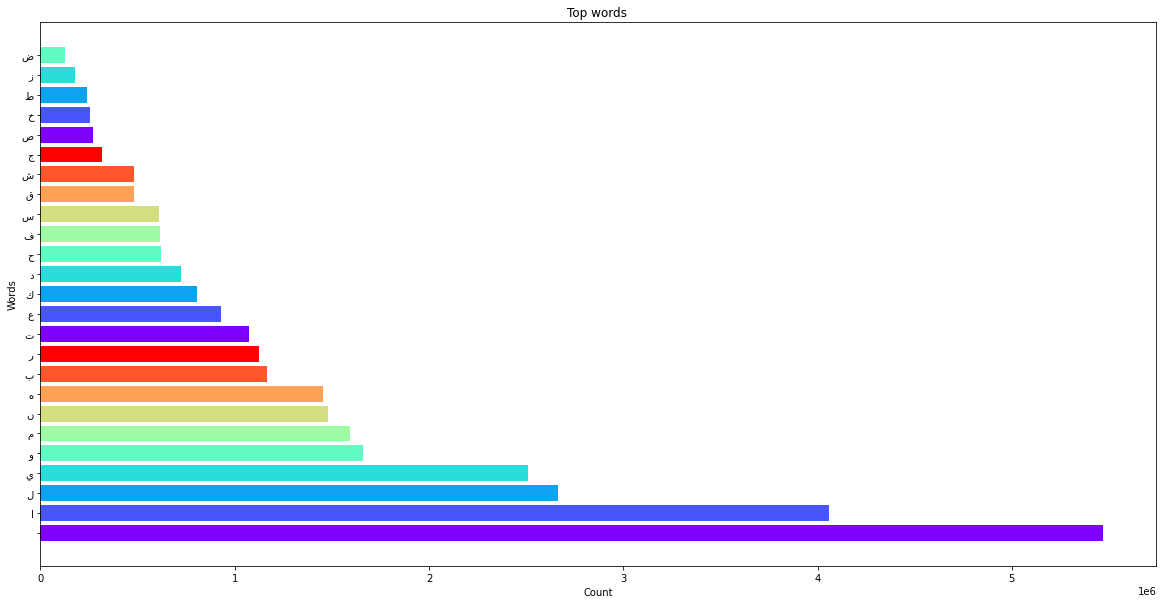

In [13]:

colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words ')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

In [14]:
df.to_csv('/content/drive/MyDrive/AIM_Task/cleaned_data.csv',index = False)